# Check GPU and Reading Lib

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

In [2]:
import tensorflow as tf
print(tf.__version__)
print(len(tf.config.list_physical_devices('GPU'))>0)

2.10.0
True


In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.4
Scikit-Learn 1.0.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [38]:
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import accuracy_score, f1_score

# Reading dataset and preprocessing

In [5]:
FINE_TUNING_EPOCHS = 3
TRAINING_EPOCHS = 3
BATCH_SIZE = 32

image_height = 180 
image_width = 180

In [6]:
base_dir = "D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/"

In [7]:
base_dataset = image_dataset_from_directory(
    base_dir,
    image_size = (image_height, image_width),
    crop_to_aspect_ratio = True,
    shuffle = False,
    batch_size = 32)

Found 40000 files belonging to 2 classes.


In [8]:
base_df = pd.DataFrame(base_dataset.file_paths.copy())
base_df.columns = ['fullpaths']
base_df['labels'] = base_df.apply(lambda x: base_dataset.class_names[1] if (base_dataset.class_names[1] in x.fullpaths)  else base_dataset.class_names[0], axis=1)
base_df['filepaths'] = base_df.apply(lambda x: str(x.fullpaths).replace(base_dir, ''), axis=1)

In [10]:
pd.set_option('display.max_colwidth', None)
base_df.head(7)

,fullpaths,labels,filepaths
0,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00001.jpg,Negative,Negative\00001.jpg
1,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00002.jpg,Negative,Negative\00002.jpg
2,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00003.jpg,Negative,Negative\00003.jpg
3,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00004.jpg,Negative,Negative\00004.jpg
4,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00005.jpg,Negative,Negative\00005.jpg
5,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00006.jpg,Negative,Negative\00006.jpg
6,D:/advLinuxAI/crackDataSet/kaggleData/Concrete20K/Negative\00007.jpg,Negative,Negative\00007.jpg


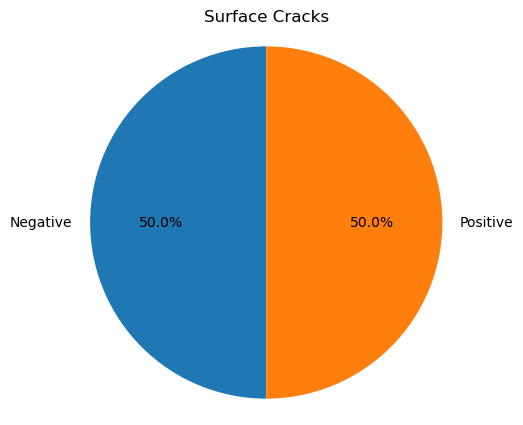

In [11]:
# Count the frequency of each label in the 'labels' column
label_counts = base_df['labels'].value_counts()

# Create a pie chart with custom settings
plt.figure(figsize=(5, 5))  # Set the figure size
plt.title('Surface Cracks')  # Set the chart title
plt.pie(label_counts, autopct='%1.1f%%', shadow=False, labels=label_counts.index, startangle=90)  # Create the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

# Show the pie chart
plt.show()

## spliting data

In [11]:
data_dir = base_dir

In [14]:
train_df, test_df = train_test_split(base_df,train_size=0.7,shuffle=True,random_state=42)

## Data generator

In [15]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [16]:
train_data = train_gen.flow_from_dataframe(
   train_df, # dataframe
    directory = base_dir, # images data path / folder in which images are there
    x_col = 'filepaths',
    y_col = 'labels',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

Found 22400 validated image filenames belonging to 2 classes.


In [17]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    directory = base_dir, # images data path / folder in which images are there
    x_col='filepaths',
    y_col='labels',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 5600 validated image filenames belonging to 2 classes.


In [18]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    directory = base_dir, # images data path / folder in which images are there
    x_col='filepaths',
    y_col='labels',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42)

Found 12000 validated image filenames belonging to 2 classes.


## show some samples

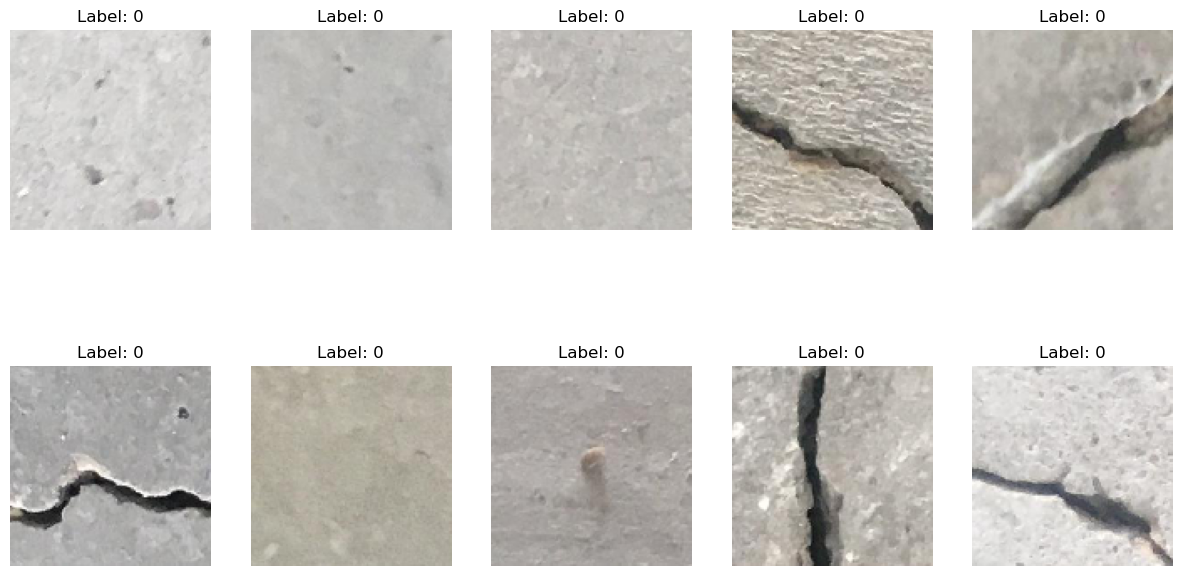

In [21]:
# Define a function to display images from the generator
def display_random_images(generator, num_images=10):
    # Get a batch of data from the generator
    batch = generator.next()
    images, labels = batch
    
    # Generate 10 random indices to select images from the batch
    random_indices = np.random.choice(len(images), num_images, replace=False)
    
    # Create a figure to display the images
    plt.figure(figsize=(15, 8))
    
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {np.argmax(labels[idx])}")
        plt.axis('off')
    
    plt.show()

# Call the function to display 10 random images from the train_generator
display_random_images(train_data, num_images=10)

# building model

visualize the training history of a machine learning model

## Visualize metrics history

In [22]:
def plot_training_history(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a new figure with specified size and font size
    plt.figure(figsize=(10, 6))
    plt.rcParams['font.size'] = 12

    # Plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    
    # Plot training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

    # Adjust subplot spacing
    plt.tight_layout(pad=3.0)

    # Show the plot
    plt.show()


In [23]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap using Seaborn
    sns.heatmap(
        cm, 
        annot=True,           # Annotate the cells with the count
        square=True,          # Make the cells square
        xticklabels=class_names,  # Labels for the x-axis
        yticklabels=class_names,  # Labels for the y-axis
        fmt='d',              # Display numbers as integers
        cmap=plt.cm.Blues,     # Color map for the heatmap
        cbar=False,           # Hide the color bar
        ax=ax                # The subplot to which the heatmap will be added
    )

    # Set the title for the plot
    ax.set_title(title, fontsize=12)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Set axis labels
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

###  Grad-CAM 

In [24]:
def make_gradcam_heatmap(image, model, last_conv_layer_name):
 
    img_array = tf.expand_dims(image, axis=0)
    
    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    
    
     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation
    
    return superimposed_img

## first Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [26]:
image_height, image_width

(180, 180)

In [27]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

In [29]:
history1 = model.fit(train_data,validation_data=val_data,epochs=10,
            callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)])

Epoch 1/10
700/700 [==============================] - 36s 44ms/step - loss: 0.4466 - accuracy: 0.8163 - val_loss: 0.2217 - val_accuracy: 0.9311
Epoch 2/10
700/700 [==============================] - 30s 43ms/step - loss: 0.1525 - accuracy: 0.9569 - val_loss: 0.1195 - val_accuracy: 0.9707
Epoch 3/10
700/700 [==============================] - 29s 42ms/step - loss: 0.0990 - accuracy: 0.9712 - val_loss: 0.1276 - val_accuracy: 0.9732
Epoch 4/10
700/700 [==============================] - 30s 42ms/step - loss: 0.0830 - accuracy: 0.9751 - val_loss: 0.1269 - val_accuracy: 0.9805
Epoch 5/10
700/700 [==============================] - 31s 44ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.0832 - val_accuracy: 0.9727
Epoch 6/10
700/700 [==============================] - 31s 45ms/step - loss: 0.0748 - accuracy: 0.9774 - val_loss: 0.0769 - val_accuracy: 0.9791
Epoch 7/10
700/700 [==============================] - 31s 44ms/step - loss: 0.0690 - accuracy: 0.9795 - val_loss: 0.0725 - val_accuracy:

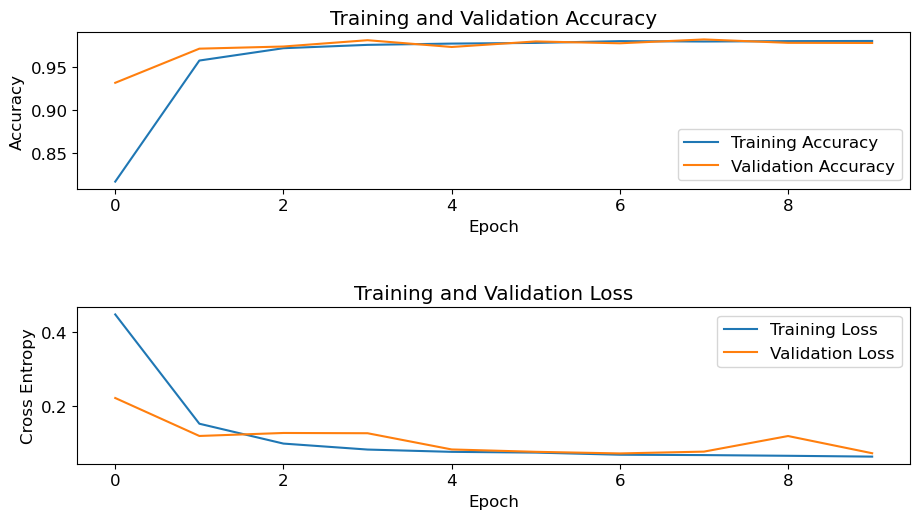

In [30]:
plot_training_history(history1)

### check the validation

In [44]:
len(train_data.labels)

22400

### Model evaluation

In [45]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))

375/375 [==============================] - 15s 39ms/step


C:\Users\mzrba\AppData\Local\Temp\ipykernel_23376\3556818576.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


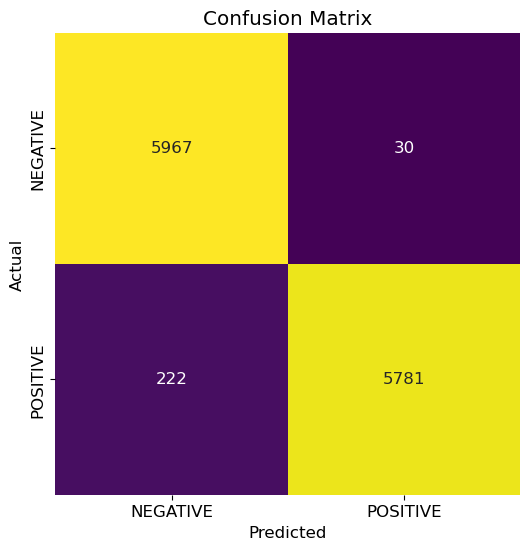

In [46]:
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Second model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, Adagrad

In [74]:
# Create a new Sequential model
new_model = Sequential()

# Add layers to the new model
new_model.add(Conv2D(64, 3, padding="same", activation="relu", input_shape=(120, 120, 3)))
new_model.add(MaxPool2D())

new_model.add(Conv2D(64, 3, padding="same", activation="relu"))
new_model.add(MaxPool2D())

new_model.add(Conv2D(128, 3, padding="same", activation="relu"))
new_model.add(MaxPool2D())

new_model.add(Flatten())
new_model.add(Dense(256, activation="relu"))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(2, activation="softmax"))

# Display the summary of the new model
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 128)     

In [79]:
opt = Adam(lr=1e-5)

new_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

In [80]:
history2 = new_model.fit(train_data,validation_data=val_data,epochs=10,
            callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)])

Epoch 1/10
700/700 [==============================] - 41s 57ms/step - loss: 0.2155 - accuracy: 0.9186 - val_loss: 0.1002 - val_accuracy: 0.9741
Epoch 2/10
700/700 [==============================] - 31s 44ms/step - loss: 0.1002 - accuracy: 0.9692 - val_loss: 0.0580 - val_accuracy: 0.9857
Epoch 3/10
700/700 [==============================] - 32s 45ms/step - loss: 0.0748 - accuracy: 0.9790 - val_loss: 0.0606 - val_accuracy: 0.9795
Epoch 4/10
700/700 [==============================] - 31s 45ms/step - loss: 0.0576 - accuracy: 0.9857 - val_loss: 0.0525 - val_accuracy: 0.9848
Epoch 5/10
700/700 [==============================] - 32s 46ms/step - loss: 0.0456 - accuracy: 0.9892 - val_loss: 0.0337 - val_accuracy: 0.9909
Epoch 6/10
700/700 [==============================] - 32s 46ms/step - loss: 0.0375 - accuracy: 0.9914 - val_loss: 0.0303 - val_accuracy: 0.9921
Epoch 7/10
700/700 [==============================] - 32s 46ms/step - loss: 0.0350 - accuracy: 0.9913 - val_loss: 0.0219 - val_accuracy:

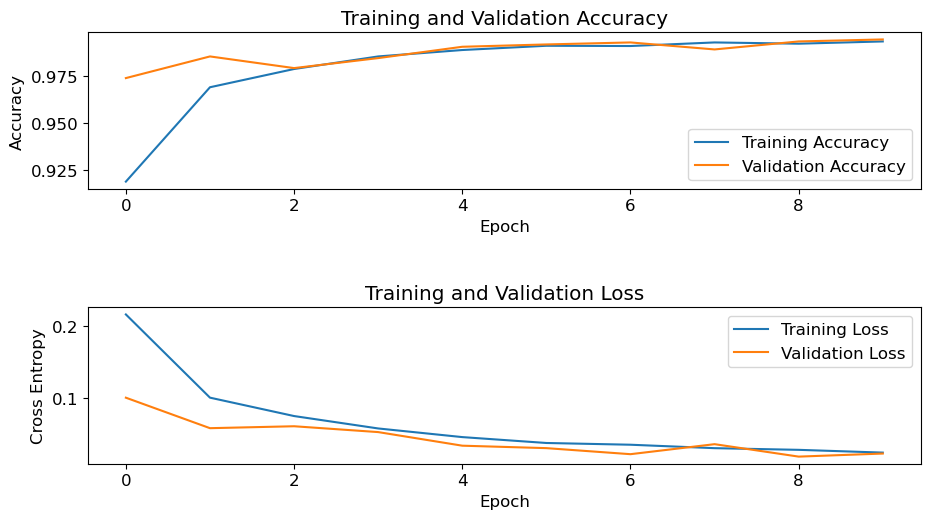

In [93]:
plot_training_history(history2)

### check the validation

In [95]:
val_predictions = new_model.predict(val_data)

175/175 [==============================] - 6s 35ms/step


In [98]:
val_predictions_binary = np.argmax(val_predictions, axis=1)
val_predictions_binary

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [101]:
val_true_labels = val_data.labels
f1 = f1_score(test_true_labels, test_predictions_binary)
print(f'F1 Score: {f1}')

F1 Score: 0.9956760352569434


### Model evaluation

In [81]:
test_loss, test_accuracy = new_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

375/375 [==============================] - 50s 134ms/step - loss: 0.0208 - accuracy: 0.9957
Test Loss: 0.02078944817185402
Test Accuracy: 0.9956666827201843


In [82]:
test_predictions = new_model.predict(test_data)

375/375 [==============================] - 13s 35ms/step


In [83]:
test_predictions

array([[1.4520642e-02, 9.8547935e-01],
       [9.9599165e-01, 4.0084273e-03],
       [1.0221391e-02, 9.8977858e-01],
       ...,
       [1.6284741e-05, 9.9998367e-01],
       [9.9385554e-01, 6.1444896e-03],
       [9.9902380e-01, 9.7616104e-04]], dtype=float32)

In [86]:
# Assuming test_predictions is a 2D array with shape (num_samples, 2)
test_predictions_binary = np.argmax(test_predictions, axis=1)
test_predictions_binary

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [89]:
test_true_labels = test_data.labels 

In [91]:
f1 = f1_score(test_true_labels, test_predictions_binary)
print(f'F1 Score: {f1}')

F1 Score: 0.9956760352569434


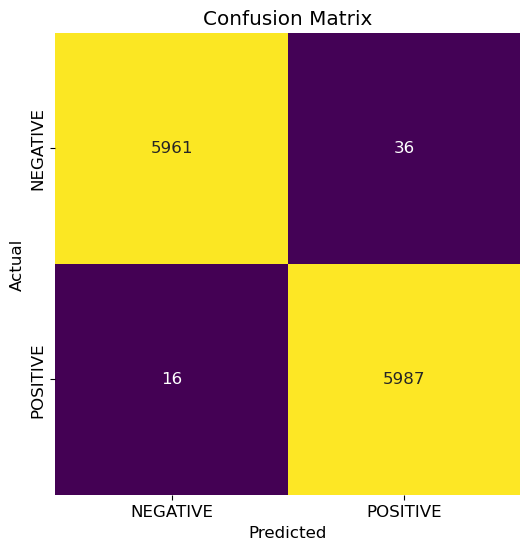

In [92]:
cm = confusion_matrix(test_true_labels, test_predictions_binary)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()